# Curve Fitting Example

In [1]:
import sys
import os
# add the directory
sys.path.append(os.path.abspath("../../Files"))

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numpy.polynomial.hermite import hermfit, hermval
import copy
# import own module
import fixed_income_derivatives_E2024 as fid

%load_ext autoreload
%autoreload 2

## Problem 1

### (a)

We would like forward rates to be positve and realtively smooth. Forward rates involve the derivative of the spot rate, hence they must be differentialble
When doing Ho-Lee we want the forward rates to be smooth and positive

In [2]:
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.00967}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.00980},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.01043},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.01130},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.01217},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.01317},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.01399},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.01478},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.01560},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.01637}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.01652, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.02019, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.02319, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.02577, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.02995, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.03395, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.03753, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.03873, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.03975, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market

In [17]:
interpolation_options = {"method":"nelson_siegel","degree":2,'transition':'smooth'}
T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options =interpolation_options)
resolution = 10
T_inter = np.array([i*(1/(resolution*12)) for i in range(0,int(T_fit[-1])*12*resolution + 1)])
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter=T_inter,T=T_fit,R=R_fit,interpolation_options = interpolation_options)

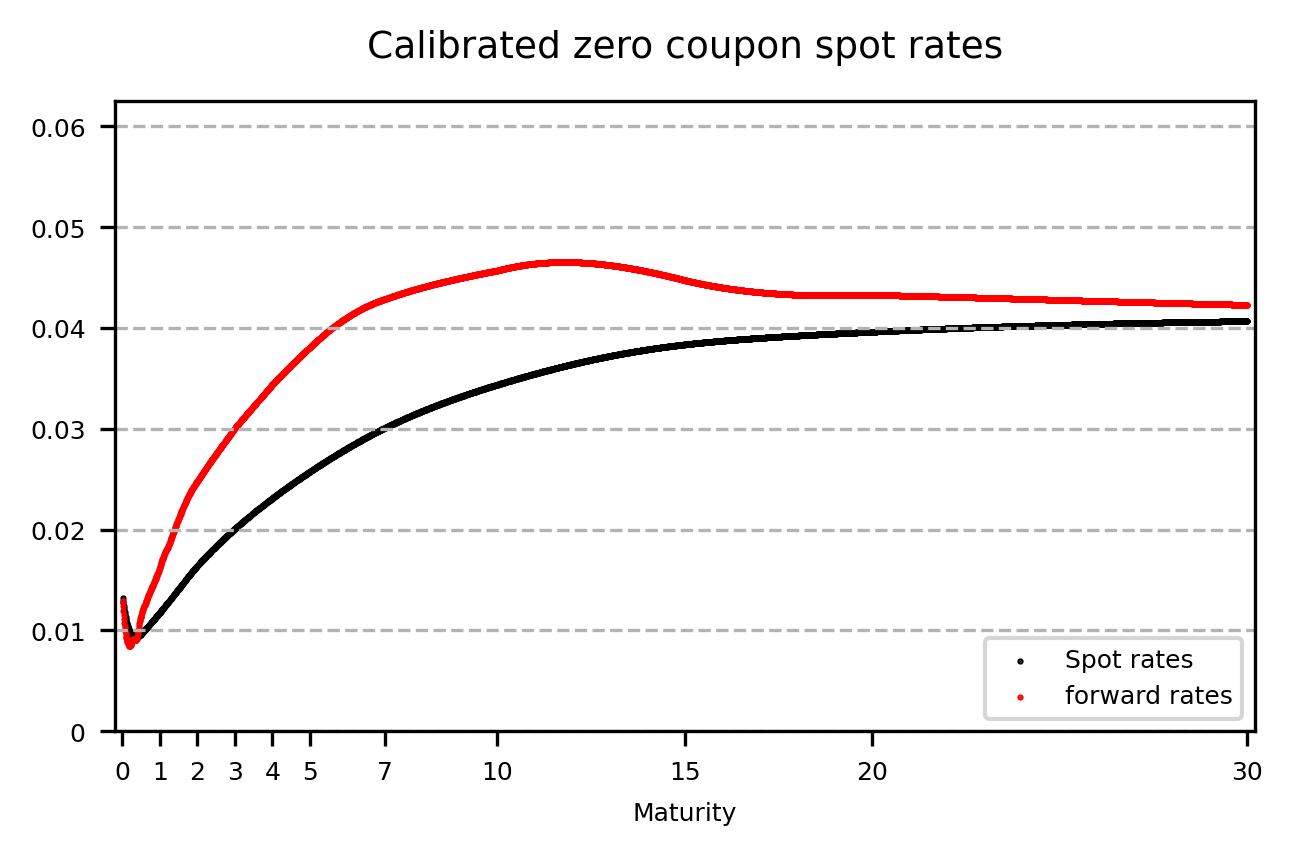

In [18]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.0625])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter[1:], R_inter[1:], s = 1, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T_inter[1:], f_inter[1:], s = 1, color = 'red', marker = ".",label="forward rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

## Problem 1

In [ ]:
# Problem 1 - Fitting the yield curve
interpolation_options = {"method":"nelson_siegel","transition": "smooth"}
# interpolation_options = {"method":"hermite","degree":2,"transition": "smooth"}
T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options = interpolation_options)
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_fit,R_fit,interpolation_options = interpolation_options,resolution = 1)
T_6m = np.array([i*0.5 for i in range(0,61)])
p_6m = np.ones(61)
p_6m[1:] = fid.for_values_in_list_find_value_return_value(T_6m[1:],T_inter,p_inter)
f_6m = fid.forward_libor_rates_from_zcb_prices(T_6m,p_6m,horizon = 1)

# c) The par swap rate curve
T_swap = np.array([i for i in range(1,31)])
R_swap, S_swap = np.zeros([len(T_swap)]), np.zeros([len(T_swap)])
for i, maturity in enumerate(T_swap):
    R_swap[i], S_swap[i] = fid.swap_rate_from_zcb_prices(0,0,T_swap[i],"annual",T_inter,p_inter)
print(f"10Y par swap rate: {R_swap[9]}, accrual factor: {S_swap[9]}")

## Problem 2

In [ ]:
# Problem 2 - Bumping spot rates and finding the DV01 of a swap
swap_id, size_bump = 15, 0.0001
print(f"Bumping spot rates")
def dv01_swap_spot_rate_bump_fct(t,T_n,T_N,fixed_freq,R_swap_init,T_bump,size_bump,T_inter,R_inter,p_inter):
    R_bump, p_bump = fid.spot_rate_bump(T_bump,size_bump,T_inter,R_inter,p_inter)
    R_swap_bump, S_swap_bump = fid.swap_rate_from_zcb_prices(t,T_n,T_N,fixed_freq,T_inter,p_bump)
    DV01 = (R_swap_bump-R_swap_init)*S_swap_bump
    return DV01

# 2a) DV01 when bumping a single spot rate
idx_bump_single = 119
R_bump = R_inter.copy()
R_bump[idx_bump_single] += size_bump
p_bump = fid.zcb_prices_from_spot_rates(T_inter,R_bump)
R_swap_bump, S_swap_bump = fid.swap_rate_from_zcb_prices(0,0,data[swap_id]["maturity"],"annual",T_inter,p_bump)
print(f"R_swap_bump: {R_swap_bump}, S_swap_bump: {S_swap_bump}")
DV01 = (R_swap_bump-data[swap_id]["rate"])*S_swap_bump
print(f"DV01 for swap {swap_id} when bumping spot_rate for T: {T_inter[idx_bump_single]} is: {10000*DV01}")
# 2a) DV01 for bumping each of the spot rates at T=[1,2,3,4,5,6,7,8,9,10]
DV01_bump = np.zeros([10])
T_bump = np.array([i for i in range(1,11)])
for i, val in enumerate(T_bump):
    DV01_bump[i] = dv01_swap_spot_rate_bump_fct(0,0,data[swap_id]["maturity"],"annual",data[swap_id]["rate"],val,size_bump,T_inter,R_inter,p_inter)
print(f"DV01 when bumping each spot rate separately: {10000*DV01_bump}")
# 2b) DV01 for bumping all of the spot rates at T=[1,2,3,4,5,6,7,8,9,10]
R_bump, p_bump = fid.spot_rate_bump(T_bump,size_bump,T_inter,R_inter,p_inter)
R_swap_bump, S_swap_bump = fid.swap_rate_from_zcb_prices(0,0,data[swap_id]["maturity"],"annual",T_inter,p_bump)
print(f"R_swap_bump: {R_swap_bump}, S_swap_bump: {S_swap_bump}")
DV01 = (R_swap_bump-data[swap_id]["rate"])*S_swap_bump
print(f"DV01 for swap {swap_id} when bumping spot_rates for T: {T_bump} is: {10000*DV01}")

## Problem 3

In [4]:
# Problem 3 - Bumping market rates and finding the DV01 of a swap
print(f"Bumping market rates")
def dv01_market_rate_bump_fct(t,T_n,T_N,fixed_freq,R_swap_init,idx_bump,size_bump,data,interpolation_options):
    p_bump, R_bump, f_bump, T_bump, data_bump = fid.market_rate_bump(idx_bump,size_bump,data,interpolation_options = interpolation_options,resolution = 1)
    R_swap_bump, S_swap_bump = fid.swap_rate_from_zcb_prices(0,0,T_N,fixed_freq,T_bump,p_bump)
    DV01 = (R_swap_bump-R_swap_init)*S_swap_bump
    return DV01

# DV01 when bumping a single market rate
idx_bump_single = 15
p_bump, R_bump, f_bump, T_bump, data_bump = fid.market_rate_bump(idx_bump_single,size_bump,data,interpolation_options = interpolation_options,resolution = 1)
R_swap_bump, S_swap_bump = fid.swap_rate_from_zcb_prices(0,0,data[swap_id]["maturity"],"annual",T_inter,p_bump)
print(f"R_swap_bump: {R_swap_bump}, S_swap_bump: {S_swap_bump}")
DV01 = (R_swap_bump-data[swap_id]["rate"])*S_swap_bump
print(f"DV01 for swap {swap_id} when bumping market rates for idx: {idx_bump_single} is: {10000*DV01}")
# DV01 when bumping each of the market rates
idx_bump_all = np.array([i for i in range(0,19)])
DV01_bump = np.zeros([19])
for i, idx in enumerate(idx_bump_all):
    DV01_bump[i] = dv01_market_rate_bump_fct(0,0,data[swap_id]["maturity"],"annual",data[swap_id]["rate"],idx,size_bump,data,interpolation_options)
print(f"DV01 when bumping each market rate separately: {10000*DV01_bump}")
# DV01 when bumping all of the market rates
p_bump, R_bump, f_bump, T_bump, data_bump = fid.market_rate_bump(idx_bump_all,size_bump,data,interpolation_options = interpolation_options,resolution = 1)
R_swap_bump, S_swap_bump = fid.swap_rate_from_zcb_prices(0,0,data[swap_id]["maturity"],"annual",T_inter,p_bump)
print(f"R_swap_bump: {R_swap_bump}, S_swap_bump: {S_swap_bump}")
DV01 = (R_swap_bump-data[swap_id]["rate"])*S_swap_bump
print(f"DV01 for swap {swap_id} when bumping spot_rates for idx: {idx_bump_all} is: {10000*DV01}")

Bumping market rates


NameError: name 'size_bump' is not defined

### Problem 4

If we have price or implied volatility we can price a swaption using Blacks Formula, else we have to simulate the shortrate until the maturity to find ZCB prices and calculate the payer swaption

1Y6Y - exercise 1 year from now, underlying is a 6 year payer swap. Swaption is a regular call option. At exercise it is just the diff between swap rate and 

# Last year's code

In [5]:
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.03478}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.03743},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.03871},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.03989},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.04098},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.04198},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.04289},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.04374},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.04452},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.04524}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.04377, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.04625, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.04777, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.04875, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.04992, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.05081, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.05148, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.05181, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.05211, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market

# a) Fitting the ZCB term structure
# interpolation_options = {"method": "linear"}
interpolation_options = {"method":"hermite","degree":3}

T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options = interpolation_options)
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_fit,R_fit,interpolation_options = interpolation_options,resolution = 1)

# Plotting the par swap rate curve
T_swap = np.array([i for i in range(1,31)])
R_swap, S_swap = np.zeros([len(T_swap)]), np.zeros([len(T_swap)])
for i, maturity in enumerate(T_swap):
    R_swap[i], S_swap[i] = fid.swap_rate_from_zcb_prices(0,0,T_swap[i],"annual",T_inter,p_inter)
    # S_swap[i] = fid.zcb_to_accrual_factor(0,T_swap[i],"semiannual",T_inter,p_inter)
    # R_swap[i] = fid.zcb_to_par_swap_rate(0,T_swap[i],"semiannual",T_inter,p_inter)

# b) Risk management of a swap position
# DVO1 when bumping one point
idx_swap, T_bump, size_bump = 15, 2, 0.0001
R_inter_bump, p_inter_bump = fid.spot_rate_bump(T_bump,size_bump,T_inter,R_inter,p_inter)
S_swap_bump = fid.zcb_to_accrual_factor(0,data[idx_swap]["maturity"],"semiannual",T_inter,p_inter_bump)
R_swap_bump = fid.zcb_to_par_swap_rate(0,data[idx_swap]["maturity"],"semiannual",T_inter,p_inter_bump)
DV01 = (R_swap_bump-data[idx_swap]["rate"])*S_swap_bump
print(f"DV01 for the swap with maturity: {data[idx_swap]['maturity']} when bumping spot rate at T: {T_bump} by {10000*size_bump} bps is {10000*DV01} bps")

# DV01 when bumping entire spot rate curve
idx_swap, size_bump = 15, -0.0001
R_inter_bump, p_inter_bump = fid.spot_rate_bump(T_inter,size_bump,T_inter,R_inter,p_inter)
S_swap_bump = fid.zcb_to_accrual_factor(0,data[idx_swap]["maturity"],"semiannual",T_inter,p_inter_bump)
R_swap_bump = fid.zcb_to_par_swap_rate(0,data[idx_swap]["maturity"],"semiannual",T_inter,p_inter_bump)
DV01 = (R_swap_bump-data[idx_swap]["rate"])*S_swap_bump
print(f"DV01 for the swap with maturity: {data[idx_swap]['maturity']} when bumping entire spot rate curve is {10000*DV01} bps")

# DV01 for bumping one of the swaps
idx_swap, idx_bump, size_bump = 15, 15, -0.0001
p_inter_bump, R_inter_bump, f_inter_bump, T_inter_bump, data_bump = fid.market_rate_bump(idx_bump,size_bump,data,interpolation_options = interpolation_options,resolution = 1)
S_swap_bump = fid.zcb_to_accrual_factor(0,data_bump[idx_swap]["maturity"],"semiannual",T_inter,p_inter_bump)
R_swap_bump = fid.zcb_to_par_swap_rate(0,data_bump[idx_swap]["maturity"],"semiannual",T_inter_bump,p_inter_bump)
DV01 = (R_swap_bump-data[idx_swap]["rate"])*S_swap_bump
print(f"DV01 for the swap with maturity: {data[idx_swap]['maturity']} when bumping the swap with maturity: {data[idx_bump]['maturity']} is {10000*DV01} bps")

# c) PnL of existing positions
T_pos, R_pos = 6, 0.048
swaption_price = 38  # price in bps
S_swap_pos = fid.zcb_to_accrual_factor(0,T_pos,"semiannual",T_inter,p_inter)
R_swap_pos = fid.zcb_to_par_swap_rate(0,T_pos,"semiannual",T_inter,p_inter)
PnL = (R_swap_pos-R_pos)*S_swap_pos
print(f"6Y par swap rate: {R_swap_pos}, S_swap: {S_swap_pos}, PnL of position in 7Y payer swap after one year: {10000*PnL} in bps.")
print(f"Market value of payer swaption now at exercise: {10000*PnL}, PnL of position in swaption: {10000*PnL-swaption_price}.")


T_set, T_mat, R_pos = 3, 8, 0.051
S_swap_pos = fid.zcb_to_accrual_factor(T_set,T_mat,"semiannual",T_inter,p_inter)
R_swap_pos = fid.zcb_to_par_swap_rate(T_set,T_mat,"semiannual",T_inter,p_inter)
PnL = (R_pos - R_swap_pos)*S_swap_pos
print(f"3Y5Y forward par swap rate: {R_swap_pos}, PnL of position in : {10000*PnL}.")




fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.0625])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter[1:], R_inter[1:], s = 1, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T_inter[1:], f_inter[1:], s = 1, color = 'red', marker = ".",label="forward rates")
p3 = ax.scatter(T_swap, R_swap, s = 1, color = 'green', marker = ".",label="par swap rates")
plots = [p1,p2,p3]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)

plt.show()

AttributeError: module 'fixed_income_derivatives_E2024' has no attribute 'spot_rate_bump'

In [ ]:
# DV01 for bumping one point on the spot curve
idx_bump, swap_dv, bump = 59, 8, 0.0001
R_bump = R_curve.copy()
R_bump[idx_bump] += bump
p_bump = fid.spot_rates_to_zcb(T_curve,R_bump)
S_swap = 0
for idx in swap_market[swap_dv]["indices"]:
    S_swap += 0.5*p_bump[idx]
R_swap = (1-p_bump[swap_market[swap_dv]["indices"][-1]])/S_swap
DV01 = (R_swap-swap_market[swap_dv]["rate"])*S_swap
print(f"DV01 for swap {swap_dv} when bumping spot_rate: {idx_bump} is: {10000*DV01} bps")

# DV01 for bumping entire the spot curve
swap_dv, bump = 8, 0.0001
R_bump = R_curve.copy()
R_bump += bump*np.ones([len(R_bump)])
p_bump = fid.spot_rates_to_zcb(T_curve,R_bump)
S_swap = 0
for idx in swap_market[swap_dv]["indices"]:
    S_swap += 0.5*p_bump[idx]
R_swap = (1-p_bump[swap_market[swap_dv]["indices"][-1]])/S_swap
DV01 = (R_swap-swap_market[swap_dv]["rate"])*S_swap
print(f"DV01 for swap {swap_dv} when bumping entire spot curve is: {10000*DV01} bps, S_swap: {S_swap}")

# DV01 for bumping one of the swaps
swap_bump, swap_dv, bump = 4, 8, 0.0001
swap_market_bump = copy.deepcopy(swap_market)
swap_market_bump[swap_bump]["rate"] += 0.0001
data_bump = EURIBOR_fixing + fra_market + swap_market_bump
T_bump, R_bump, data_bump = fid.zcb_curve_fit(data_bump)
p_bump = fid.spot_rates_to_zcb(T_bump,R_bump)
S_swap = 0
for idx in swap_market_bump[swap_dv]["indices"]:
    S_swap += 0.5*p_bump[idx]
R_swap = (1-p_bump[swap_market_bump[swap_dv]["indices"][-1]])/S_swap
DV01 = (R_swap-swap_market[swap_dv]["rate"])*S_swap
print(f"DV01 for swap {swap_dv} when bumping market rate for: {swap_bump} is: {10000*DV01} bps")


NameError: name 'R_curve' is not defined

In [ ]:
# T_inter = [i*1/12 for i in range(1,12*30)]
# R_inter = fid.interpolate(T_curve,R_curve,T_inter,interpolation_options)
# p_inter = fid.spot_rates_to_zcb(T_inter,R_inter)
# f_inter = fid.zcb_to_forward_rates(T_inter,p_inter,horizon = 0)